# Credit Card Default Demo

In [63]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method, dice_method
from core import recourse_iterator
from data import data_loader
from data.adapters import continuous_adapter
from core import utils
from models import model_interface, model_loader, model_constants
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

In [64]:
dataset, dataset_info = data_loader.load_data(data_loader.DatasetName.CREDIT_CARD_DEFAULT)
adapter = continuous_adapter.StandardizingAdapter(label_name=dataset_info.label_name, positive_label=dataset_info.positive_label).fit(dataset)
dataset

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,689,0,0,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,43,0,0,0,0,0,0,1683,1828,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,37,4,3,2,0,0,0,3565,3356,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


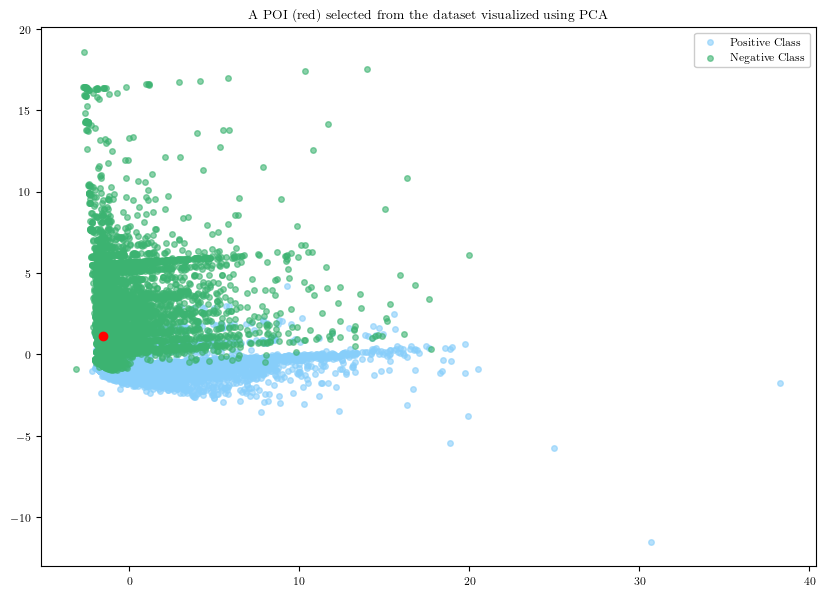

In [67]:
model = model_loader.load_model(
    model_type=model_constants.ModelType.LOGISTIC_REGRESSION,
    dataset_name=data_loader.DatasetName.CREDIT_CARD_DEFAULT,
    model_name=model_constants.ModelName.DEFAULT)

dataset[dataset_info.label_name] = model.predict(dataset)

poi = utils.random_poi(dataset, column='Y', label=adapter.negative_label)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = dataset_info.positive_label,
    title="A POI (red) selected from the dataset visualized using PCA"
).set_poi(adapter.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

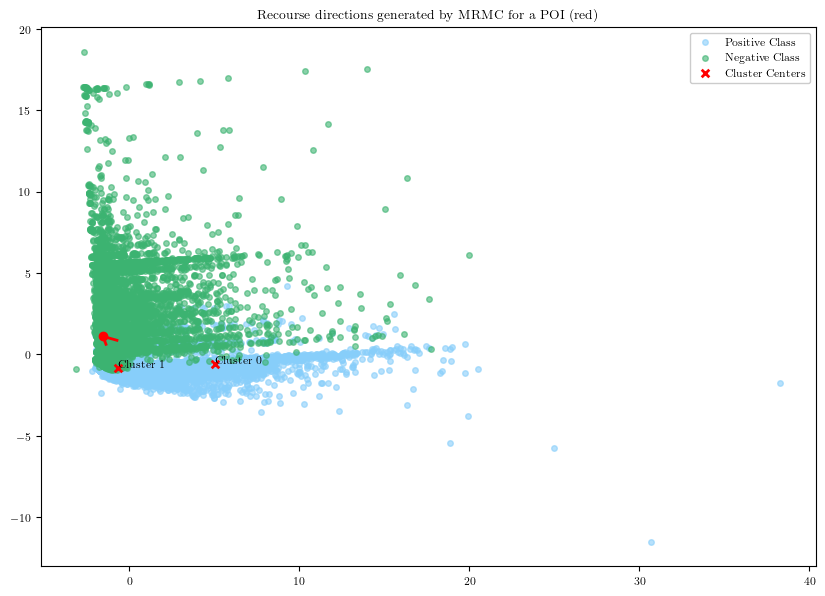

In [68]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = adapter.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Recourse directions generated by MRMC for a POI (red)"
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

final certainty for path 0: 0.5237255393708103
final certainty for path 1: 0.5143226776001392


(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:title={'center':'Iterated recourse paths generated by MRMC for a POI (red)'}>)

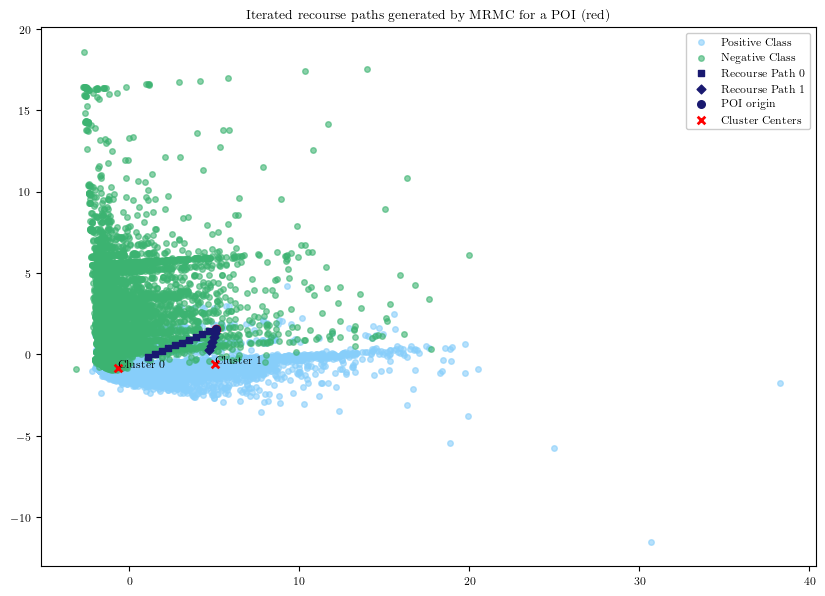

In [69]:
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Iterated recourse paths generated by MRMC for a POI (red)"
)

poi = utils.random_poi(dataset, column='Y', label = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [9]:
paths[0]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,90000.000000,35.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,35077.000000,37557.000000,29355.000000,20046.000000,14905.000000,15075.000000,3407.000000,56.000000,603.000000,553.000000,430.000000,133.000000
1,97384.486231,34.973205,1.771221,1.776105,1.782620,0.005159,0.002635,0.004688,34381.854471,36298.424494,28784.189190,20214.382377,15432.675871,15474.392274,3480.858984,510.872538,935.256068,852.854633,741.719294,501.663141
2,104587.321518,34.940105,1.542400,1.552048,1.565054,0.010032,0.005103,0.009091,33654.374848,35008.431938,28182.483920,20353.494395,15930.788748,15843.540236,3544.465689,955.119683,1257.520213,1142.220621,1043.194815,857.405302
3,111541.748719,34.898363,1.313691,1.327761,1.347092,0.014501,0.007344,0.013099,32882.712633,33675.467986,27538.292180,20451.880452,16387.865086,16171.095256,3594.641932,1385.573034,1566.656302,1417.985745,1331.404383,1196.669381
4,118149.562986,34.844338,1.085377,1.103173,1.128360,0.018391,0.009271,0.016554,32048.012561,32281.054002,26833.084339,20491.219277,16785.692087,16439.181329,3626.722649,1797.691915,1858.096569,1675.671543,1601.982802,1514.422649
5,124263.274968,34.771921,0.857913,0.878261,0.908244,0.021445,0.010755,0.019225,31116.990144,30792.442912,26034.389047,20439.890799,17093.263591,16617.575041,3633.435138,2184.596466,2124.887666,1908.503703,1848.311112,1803.188216
6,129652.459569,34.670029,0.631991,0.653134,0.685835,0.023270,0.011606,0.020764,30024.853213,29146.039437,25080.300821,20239.121025,17253.982504,16651.371903,3602.747882,2535.015240,2355.798533,2105.558863,2059.710733,2051.128561
7,133939.139750,34.517056,0.408634,0.428164,0.460041,0.023261,0.011533,0.020643,28632.429961,27206.588996,23841.919032,19770.028326,17155.811609,16432.164449,3513.416199,2828.472682,2531.126502,2247.691371,2217.473837,2237.839798


In [10]:
paths[1]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,90000.000000,35.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,35077.000000,37557.000000,29355.000000,20046.000000,14905.000000,15075.000000,3407.000000,56.000000,603.000000,553.000000,430.000000,133.000000
1,101890.712220,35.100808,1.849085,1.848780,1.853366,0.003356,0.002862,0.004990,45156.603740,47161.633523,39127.528871,29603.844010,24065.328017,23829.250609,4040.123321,929.000565,1287.433123,1171.879280,1050.539279,758.174627
2,113683.489335,35.199263,1.697394,1.696809,1.706025,0.006661,0.005654,0.009903,55220.782329,56743.428935,48877.077367,39143.170620,33210.708765,32570.030335,4650.806546,1779.631434,1952.336311,1774.340793,1655.572499,1367.821952
3,125354.878359,35.294634,1.544786,1.543948,1.557825,0.009890,0.008350,0.014704,65263.165037,66294.963625,58596.879269,48659.515704,42338.290359,41295.251970,5235.077860,2603.909320,2594.694491,2357.769838,2242.577063,1959.520046
4,136873.238064,35.385853,1.391075,1.390017,1.408560,0.013002,0.010913,0.019338,75274.314486,75805.590526,68277.385194,58146.730090,51444.307248,50002.326783,5787.989282,3396.899872,3210.850412,2918.940754,2808.441888,2530.289078
5,148194.718484,35.471319,1.236028,1.234788,1.257945,0.015939,0.013290,0.023725,85240.004820,85259.701291,77904.822245,67596.123039,60523.665652,58688.023071,6303.267734,4152.418079,3796.301638,3453.800404,3349.263336,3076.398623
6,159256.592194,35.548554,1.079336,1.077959,1.105566,0.018612,0.015406,0.027742,95138.343373,94633.857771,87458.844705,76995.064258,69569.306134,67348.324719,6772.776806,4862.596138,4345.394872,3957.139380,3860.035067,3593.077018
7,169965.783624,35.613620,0.920594,0.919134,0.950810,0.020889,0.017151,0.031202,104934.812505,103891.951311,96908.616476,86324.681359,78571.263449,75978.423237,7185.650462,5517.227004,4850.841253,4422.075047,4334.158819,4074.054080
8,180178.573229,35.660111,0.759268,0.757788,0.792759,0.022569,0.018369,0.033817,114573.523967,112976.979951,106206.239391,95556.205140,87515.548448,84573.396305,7526.854881,6102.693012,5302.909083,4839.213670,4762.650747,4510.812219
9,189664.572719,35.677520,0.594677,0.593252,0.630071,0.023356,0.018828,0.035149,123961.876366,121797.619773,115276.266790,104646.236194,96384.283004,93131.816472,7774.787905,6600.073866,5688.043793,5195.276690,5132.853325,4891.338974


# Now try DiCE

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


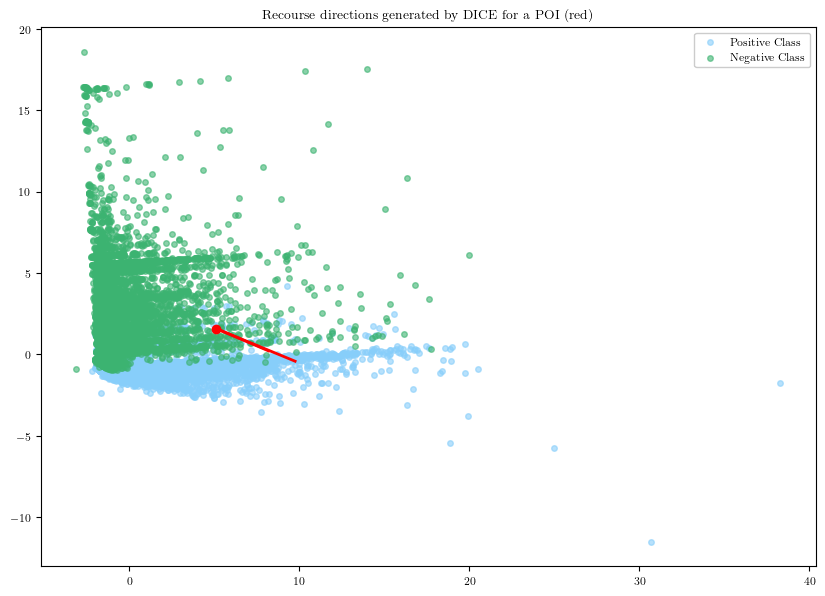

In [70]:
k_directions = 2
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

poix = adapter.transform_series(poi)
dirs = dice.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Recourse directions generated by DICE for a POI (red)"
).do_pca().set_poi(poix).set_dirs(dirs, poix).scatter()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


final certainty for path 0: 0.9995219458931006
final certainty for path 1: 0.6228374649638097


(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:title={'center':'Iterated recourse paths generated by DICE for a POI (red)'}>)

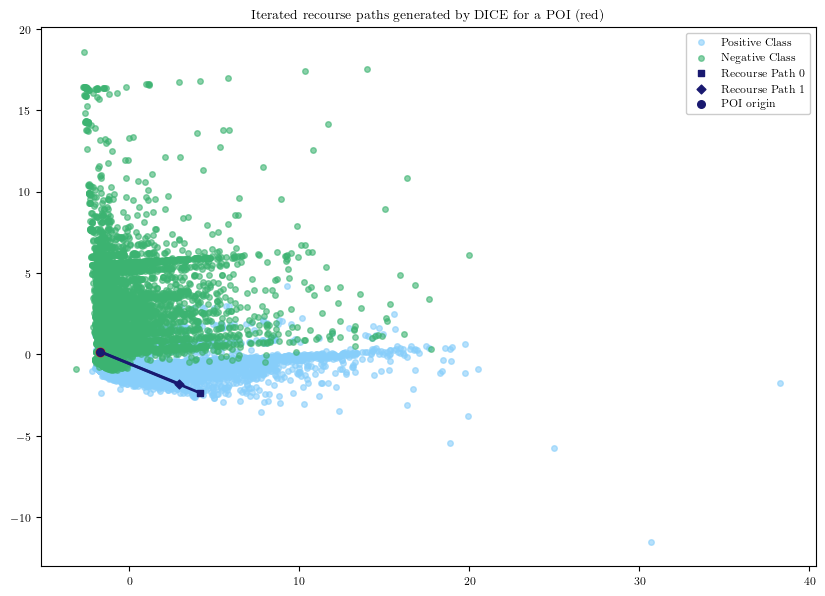

In [71]:
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Iterated recourse paths generated by DICE for a POI (red)"
)

poi = utils.random_poi(dataset, column='Y', label = 1)

iterator = recourse_iterator.RecourseIterator(
    dice,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).scatter()